In [3]:
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /opt/bitnami/python/lib/python3.11/site-packages/pip-23.3.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# start spark session and setup minio configuration
spark = SparkSession.builder \
    .appName("MinIO Integration") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.host", "jupyter-notebook") \
    .config("spark.driver.bindAddress", "0.0.0.0") \
    .config("spark.jars", "/opt/spark/jars/hadoop-aws-3.3.1.jar,/opt/spark/jars/aws-java-sdk-bundle-1.12.262.jar") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.connection.maximum", "50") \
    .config("spark.hadoop.fs.s3a.threads.core", "20") \
    .config("spark.hadoop.fs.s3a.connection.timeout", "5000") \
    .config("spark.hadoop.fs.s3a.retry.limit", "10") \
    .config("spark.hadoop.fs.s3a.attempts.maximum", "10") \
    .config("spark.hadoop.fs.s3a.multipart.size", "104857600") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1") \
    .getOrCreate()


In [10]:
# read AAPL data from minio
df = spark.read.csv("s3a://your-bucket/AAPL.csv", header=True, inferSchema=True)
df.show()

24/10/26 13:49:20 INFO InMemoryFileIndex: It took 7 ms to list leaf files for 1 paths.
24/10/26 13:49:20 INFO InMemoryFileIndex: It took 6 ms to list leaf files for 1 paths.
24/10/26 13:49:20 INFO FileSourceStrategy: Pushed Filters: 
24/10/26 13:49:20 INFO FileSourceStrategy: Post-Scan Filters: (length(trim(value#247, None)) > 0)
24/10/26 13:49:20 INFO MemoryStore: Block broadcast_15 stored as values in memory (estimated size 215.0 KiB, free 433.9 MiB)
24/10/26 13:49:20 INFO MemoryStore: Block broadcast_15_piece0 stored as bytes in memory (estimated size 35.7 KiB, free 433.9 MiB)
24/10/26 13:49:20 INFO BlockManagerInfo: Added broadcast_15_piece0 in memory on jupyter-notebook:34427 (size: 35.7 KiB, free: 434.3 MiB)
24/10/26 13:49:20 INFO SparkContext: Created broadcast 15 from csv at NativeMethodAccessorImpl.java:0
24/10/26 13:49:20 INFO FileSourceScanExec: Planning scan with bin packing, max size: 4194304 bytes, open cost is considered as scanning 4194304 bytes.
24/10/26 13:49:20 INFO 

+----------+------------------+------------------+------------------+------------------+------------------+---------+
|      Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|
+----------+------------------+------------------+------------------+------------------+------------------+---------+
|2023-01-03|130.27999877929688|130.89999389648438|124.16999816894531|125.06999969482422|124.37480163574219|112117500|
|2023-01-04|126.88999938964844|128.66000366210938|125.08000183105469|126.36000061035156|125.65763854980469| 89113600|
|2023-01-05|127.12999725341797| 127.7699966430664|124.76000213623047| 125.0199966430664|124.32508087158203| 80962700|
|2023-01-06|126.01000213623047| 130.2899932861328|124.88999938964844| 129.6199951171875| 128.8994903564453| 87754700|
|2023-01-09|130.47000122070312|133.41000366210938|129.88999938964844|130.14999389648438| 129.4265594482422| 70790800|
|2023-01-10|130.25999450683594|131.25999450683594| 128.1

24/10/26 13:49:20 INFO BlockManagerInfo: Added broadcast_17_piece0 in memory on 172.18.0.7:33187 (size: 35.7 KiB, free: 1048.7 MiB)
24/10/26 13:49:20 INFO TaskSetManager: Finished task 0.0 in stage 13.0 (TID 10) in 70 ms on 172.18.0.7 (executor 0) (1/1)
24/10/26 13:49:20 INFO TaskSchedulerImpl: Removed TaskSet 13.0, whose tasks have all completed, from pool 
24/10/26 13:49:20 INFO DAGScheduler: ResultStage 13 (csv at NativeMethodAccessorImpl.java:0) finished in 0.079 s
24/10/26 13:49:20 INFO DAGScheduler: Job 10 is finished. Cancelling potential speculative or zombie tasks for this job
24/10/26 13:49:20 INFO TaskSchedulerImpl: Killing all running tasks in stage 13: Stage finished
24/10/26 13:49:20 INFO DAGScheduler: Job 10 finished: csv at NativeMethodAccessorImpl.java:0, took 0.082047 s
24/10/26 13:49:20 INFO FileSourceStrategy: Pushed Filters: 
24/10/26 13:49:20 INFO FileSourceStrategy: Post-Scan Filters: 
24/10/26 13:49:20 INFO MemoryStore: Block broadcast_19 stored as values in mem

In [23]:

transform_start_time = datetime.now()
print(transform_start_time)

# Cast 'Adj Close' and 'Date' to correct types
df = df.withColumn("Adj Close", col("Adj Close").cast("double")) \
       .withColumn("Date", col("Date").cast("date"))

# Define a function to add moving average columns
def add_moving_average(df, window_size):
    window_spec = Window.orderBy("Date").rowsBetween(-window_size + 1, 0)
    return df.withColumn(f"Moving_Avg_{window_size}", avg("Adj Close").over(window_spec))

# Add multiple moving averages (5, 10, 20, 30, 60, and 90 days)
for window in [5, 10, 20, 30, 60, 90]:
    df = add_moving_average(df, window)

declair_end_time = datetime.now()
print(declair_end_time)

print(f"declair_time_spend : {(declair_end_time - transform_start_time)}")

print(f"total process data count: {df.count()}")
print(f"total time spend after count : {(datetime.now() - transform_start_time)}")
print(f"total process data count: {df.count()}")
print(f"total process data count: {df.count()}")
print(f"total process data count: {df.count()}")
print(f"total process data count: {df.count()}")
print(f"total process data count: {df.count()}")
print(f"total process data count: {df.count()}")
print(f"total time spend after count : {(datetime.now() - transform_start_time)}")
#df.show()

# Convert the PySpark DataFrame back to Pandas for plotting
pd_df = df.select("Date", "Adj Close", "Moving_Avg_5", "Moving_Avg_10", "Moving_Avg_20", 
                  "Moving_Avg_30", "Moving_Avg_60", "Moving_Avg_90").toPandas()


2024-10-26 13:54:12.006404
2024-10-26 13:54:12.102443
declair_time_spend : 0:00:00.096039
total process data count: 187
total time spend after count : 0:00:00.172128


24/10/26 13:54:12 INFO FileSourceStrategy: Pushed Filters: 
24/10/26 13:54:12 INFO FileSourceStrategy: Post-Scan Filters: 
24/10/26 13:54:12 INFO MemoryStore: Block broadcast_114 stored as values in memory (estimated size 214.9 KiB, free 432.4 MiB)
24/10/26 13:54:12 INFO MemoryStore: Block broadcast_114_piece0 stored as bytes in memory (estimated size 35.6 KiB, free 432.4 MiB)
24/10/26 13:54:12 INFO BlockManagerInfo: Added broadcast_114_piece0 in memory on jupyter-notebook:34427 (size: 35.6 KiB, free: 434.1 MiB)
24/10/26 13:54:12 INFO SparkContext: Created broadcast 114 from count at NativeMethodAccessorImpl.java:0
24/10/26 13:54:12 INFO FileSourceScanExec: Planning scan with bin packing, max size: 4194304 bytes, open cost is considered as scanning 4194304 bytes.
24/10/26 13:54:12 INFO DAGScheduler: Registering RDD 277 (count at NativeMethodAccessorImpl.java:0) as input to shuffle 34
24/10/26 13:54:12 INFO DAGScheduler: Got map stage job 74 (count at NativeMethodAccessorImpl.java:0) wi

total process data count: 187
total process data count: 187
total process data count: 187


24/10/26 13:54:12 INFO FileSourceStrategy: Pushed Filters: 
24/10/26 13:54:12 INFO FileSourceStrategy: Post-Scan Filters: 
24/10/26 13:54:12 INFO MemoryStore: Block broadcast_123 stored as values in memory (estimated size 214.9 KiB, free 432.4 MiB)
24/10/26 13:54:12 INFO MemoryStore: Block broadcast_123_piece0 stored as bytes in memory (estimated size 35.6 KiB, free 432.4 MiB)
24/10/26 13:54:12 INFO BlockManagerInfo: Added broadcast_123_piece0 in memory on jupyter-notebook:34427 (size: 35.6 KiB, free: 434.1 MiB)
24/10/26 13:54:12 INFO SparkContext: Created broadcast 123 from count at <unknown>:0
24/10/26 13:54:12 INFO FileSourceScanExec: Planning scan with bin packing, max size: 4194304 bytes, open cost is considered as scanning 4194304 bytes.
24/10/26 13:54:12 INFO DAGScheduler: Registering RDD 298 (count at <unknown>:0) as input to shuffle 37
24/10/26 13:54:12 INFO DAGScheduler: Got map stage job 80 (count at <unknown>:0) with 1 output partitions
24/10/26 13:54:12 INFO DAGScheduler: 

total process data count: 187
total process data count: 187
total process data count: 187
total time spend after count : 0:00:00.611757


24/10/26 13:54:12 INFO MapOutputTrackerMasterEndpoint: Asked to send map output locations for shuffle 39 to 172.18.0.7:37740
24/10/26 13:54:12 INFO BlockManagerInfo: Removed broadcast_126_piece0 on jupyter-notebook:34427 in memory (size: 35.6 KiB, free: 434.1 MiB)
24/10/26 13:54:12 INFO BlockManagerInfo: Removed broadcast_126_piece0 on 172.18.0.7:33187 in memory (size: 35.6 KiB, free: 1048.5 MiB)
24/10/26 13:54:12 INFO TaskSetManager: Finished task 0.0 in stage 125.0 (TID 85) in 15 ms on 172.18.0.7 (executor 0) (1/1)
24/10/26 13:54:12 INFO TaskSchedulerImpl: Removed TaskSet 125.0, whose tasks have all completed, from pool 
24/10/26 13:54:12 INFO DAGScheduler: ResultStage 125 (count at <unknown>:0) finished in 0.022 s
24/10/26 13:54:12 INFO BlockManagerInfo: Removed broadcast_128_piece0 on jupyter-notebook:34427 in memory (size: 5.8 KiB, free: 434.1 MiB)
24/10/26 13:54:12 INFO DAGScheduler: Job 85 is finished. Cancelling potential speculative or zombie tasks for this job
24/10/26 13:54:

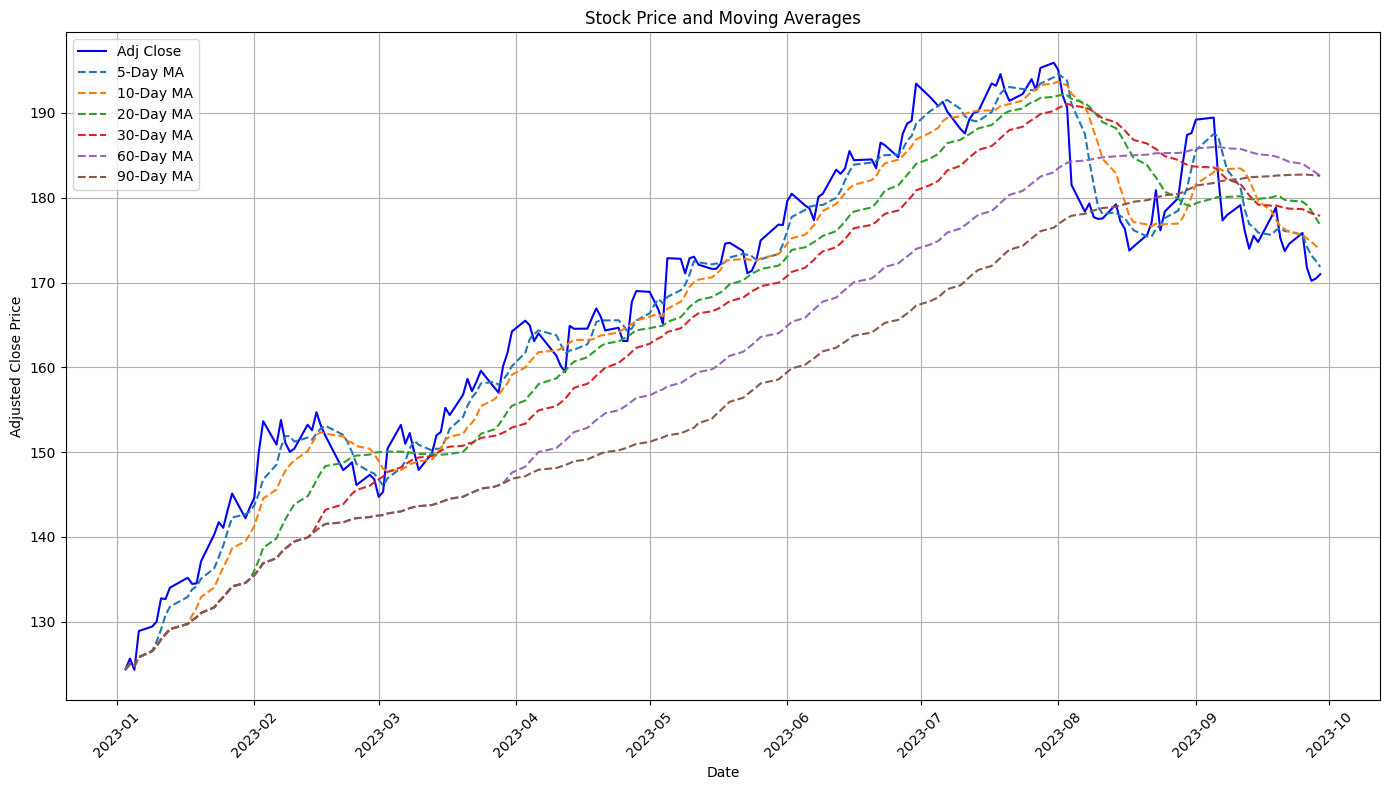

24/10/26 09:55:52 INFO BlockManagerInfo: Removed broadcast_14_piece0 on jupyter-notebook:34427 in memory (size: 17.0 KiB, free: 434.4 MiB)
24/10/26 09:55:52 INFO BlockManagerInfo: Removed broadcast_14_piece0 on 172.18.0.7:33187 in memory (size: 17.0 KiB, free: 1048.8 MiB)


In [8]:

# Plot the data using matplotlib
plt.figure(figsize=(14, 8))
plt.plot(pd_df['Date'], pd_df['Adj Close'], label='Adj Close', color='blue')
plt.plot(pd_df['Date'], pd_df['Moving_Avg_5'], label='5-Day MA', linestyle='--')
plt.plot(pd_df['Date'], pd_df['Moving_Avg_10'], label='10-Day MA', linestyle='--')
plt.plot(pd_df['Date'], pd_df['Moving_Avg_20'], label='20-Day MA', linestyle='--')
plt.plot(pd_df['Date'], pd_df['Moving_Avg_30'], label='30-Day MA', linestyle='--')
plt.plot(pd_df['Date'], pd_df['Moving_Avg_60'], label='60-Day MA', linestyle='--')
plt.plot(pd_df['Date'], pd_df['Moving_Avg_90'], label='90-Day MA', linestyle='--')

# Formatting the plot
plt.title('Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()